In [214]:
import pandas as pd
import numpy as np
import json
import ast
from tqdm import tqdm
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from neo4j import GraphDatabase, basic_auth
import random
from scipy.stats import sem
import openai
import os
from dotenv import load_dotenv, find_dotenv

In [215]:
config_file = os.path.join(os.path.expanduser('~'), '.gpt_config.env')
load_dotenv(config_file)
api_key = os.environ.get('API_KEY')
api_version = os.environ.get('API_VERSION')
resource_endpoint = os.environ.get('RESOURCE_ENDPOINT')
openai.api_type = "azure"
openai.api_key = api_key
openai.api_base = resource_endpoint
openai.api_version = api_version


In [216]:
def jaccard_similarity(list1, list2):
    if list1 is not None and list2 is not None and len(list1) > 0 and len(list2) > 0:
        list1 = [item.lower() for item in list1]
        list2 = [item.lower() for item in list2]

        set1 = set(list1)
        set2 = set(list2)
        intersection = len(set1.intersection(set2))
        union = len(set1) + len(set2) - intersection
        if union == 0:
            return 0.0
        else:
            jaccard_similarity = intersection / union
            return jaccard_similarity
    else:
        return 0.0

    
def extract_dict_items(input_string):
    match = re.search(r'\[([^]]*)\]', input_string)
    if match:
        compounds = match.group(1).split(', ')
        return compounds
    else:
        return None

def extract_numbered_items(input_string):
    pattern = r'\d+\.\s+([^\n]+)'
    matches = re.findall(pattern, input_string)
    item_names = []
    for match in matches:
        item_name = match.split(':')[0].strip()
        item_name = item_name.split('-')[0].strip()  # Remove any text after "-"
        item_names.append(item_name)
    return item_names

def extract_answer(text):
    pattern = r'{[^{}]*}'
    match = re.search(pattern, text)
    if match:
        return match.group()
    else:
        return None
    


In [217]:
PARENT_PATH = "../../../data/analysis_results/"

GPT_FILES = [
    "gpt_35_turbo_entity_recognition_based_node_retrieval_rag_based_drug_repurposing_questions_response_v2.csv",
    "gpt_4_entity_recognition_based_node_retrieval_rag_based_drug_repurposing_questions_response_v2.csv"
]
LLAMA_FILES = [
    "Llama_2_13b_chat_hf_entity_recognition_based_node_retrieval_rag_based_drug_repurposing_questions_response_v2.csv"
]

GPT_MODEL_LIST = ["GPT-3.5-Turbo", "GPT-4"]
LLAMA_MODEL_LIST = ["Llama-2-13b"]


MODEL_LIST = ["Llama-2-13b", "GPT-3.5-Turbo", "GPT-4"]


In [218]:
llama_df = pd.read_csv(os.path.join(PARENT_PATH, LLAMA_FILES[0]))
llama_performance_list = []
for index, row in llama_df.iterrows():
    groundTruth = ast.literal_eval(row["compoundGroundTruth"])
    extracted_answer = extract_answer(row["llm_answer"])
    if extracted_answer:
        extracted_answer = extract_dict_items(extracted_answer)
    else:
        extracted_answer = extract_numbered_items(row["llm_answer"])
    llama_performance_list.append(jaccard_similarity(groundTruth, extracted_answer))
llama_drug_repurpose_perf = pd.DataFrame({
    'performance_mean': [np.mean(llama_performance_list)],
    'performance_std': [np.std(llama_performance_list)],
    'performance_sem': [sem(llama_performance_list)],
    'model_name': LLAMA_MODEL_LIST
})

gpt_35_df = pd.read_csv(os.path.join(PARENT_PATH, GPT_FILES[0]))
gpt_35_performance_list = []
for index, row in gpt_35_df.iterrows():
    groundTruth = ast.literal_eval(row["compoundGroundTruth"])
    extracted_answer = json.loads(row["llm_answer"])["Compounds"]
    gpt_35_performance_list.append(jaccard_similarity(groundTruth, extracted_answer))
gpt_35_drug_repurpose_perf = pd.DataFrame({
    'performance_mean': [np.mean(gpt_35_performance_list)],
    'performance_std': [np.std(gpt_35_performance_list)],
    'performance_sem': [sem(gpt_35_performance_list)],
    'model_name': GPT_MODEL_LIST[0]
})

gpt_4_df = pd.read_csv(os.path.join(PARENT_PATH, GPT_FILES[1]))
gpt_4_performance_list = []
for index, row in gpt_4_df.iterrows():
    groundTruth = ast.literal_eval(row["compoundGroundTruth"])
    extracted_answer = json.loads(row["llm_answer"])["Compounds"]
    gpt_4_performance_list.append(jaccard_similarity(groundTruth, extracted_answer))
gpt_4_drug_repurpose_perf = pd.DataFrame({
    'performance_mean': [np.mean(gpt_4_performance_list)],
    'performance_std': [np.std(gpt_4_performance_list)],
    'performance_sem': [sem(gpt_4_performance_list)],
    'model_name': GPT_MODEL_LIST[1]
})


In [219]:
llm_drug_repurpose_perf = pd.concat([llama_drug_repurpose_perf, gpt_35_drug_repurpose_perf, gpt_4_drug_repurpose_perf], ignore_index=True)
llm_drug_repurpose_perf


,performance_mean,performance_std,performance_sem,model_name
0,0.448763,0.346651,0.042350,Llama-2-13b
1,0.644138,0.349948,0.042753,GPT-3.5-Turbo
2,0.756671,0.286475,0.034998,GPT-4


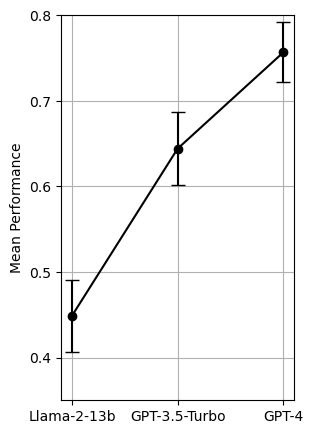

In [220]:


params = MODEL_LIST
mean_performance = llm_drug_repurpose_perf.performance_mean.values
std_deviation = llm_drug_repurpose_perf.performance_std.values
sem_value = llm_drug_repurpose_perf.performance_sem.values

fig = plt.figure(figsize=(3, 5))
plt.errorbar(params, mean_performance, yerr=sem_value, fmt='o-', capsize=5, label='Performance', color="black")
plt.ylabel('Mean Performance')
plt.grid(True)
plt.ylim(0.35,0.8)
plt.show()

# figure_folder_name = "drug_repurposing"
# fig_filename = "../../../data/analysis_results/figures/{}/performance_comparison_line_plot_v2.svg".format(figure_folder_name)
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')



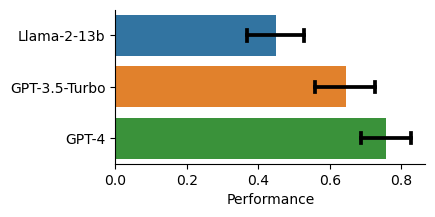

In [221]:
list1 = llama_performance_list
list2 = gpt_35_performance_list
list3 = gpt_4_performance_list
data_to_plot = pd.DataFrame({
    'Model': [MODEL_LIST[0]] * len(list1) + [MODEL_LIST[1]] * len(list2) + [MODEL_LIST[2]] * len(list3),
    'Performance': list1 + list2 + list3
})

fig = plt.figure(figsize=(4, 2))
# bar_plot = sns.barplot(x='Model', y='Performance', data=data_to_plot, capsize=0.2, errcolor='k', errorbar=("ci", 95))
bar_plot = sns.barplot(x='Performance', y='Model', data=data_to_plot, capsize=0.2, errcolor='black', errorbar=("ci", 95))
# bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)
sns.despine(top=True, right=True)
plt.xlabel('Performance')
plt.ylabel('')
plt.show()

# figure_folder_name = "drug_repurposing"
# fig_filename = "../../../data/analysis_results/figures/{}/performance_comparison_box_plot_v2.svg".format(figure_folder_name)
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


In [230]:
MODEL_LIST

['Llama-2-13b', 'GPT-3.5-Turbo', 'GPT-4']

In [232]:
import scipy.stats as st

subset = data_to_plot[data_to_plot.Model == "GPT-4"]

mean_performance = subset['Performance'].mean()

sem = st.sem(subset['Performance'])

ci = st.t.interval(alpha=0.95, df=len(subset['Performance'])-1, loc=mean_performance, scale=sem)

print("Mean : ", mean_performance)
print("SEM : ", sem)
print(f"The 95% confidence interval is {ci}")


Mean :  0.7566705824010453
SEM :  0.03499844743898423
The 95% confidence interval is (0.6868133889541594, 0.8265277758479312)


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_10929/1245357783.py:9: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  ci = st.t.interval(alpha=0.95, df=len(subset['Performance'])-1, loc=mean_performance, scale=sem)


In [233]:
data_to_plot

,Model,Performance
0,Llama-2-13b,0.666667
1,Llama-2-13b,0.214286
2,Llama-2-13b,0.185185
3,Llama-2-13b,0.800000
4,Llama-2-13b,0.000000
...,...,...
199,GPT-4,0.500000
200,GPT-4,0.818182
201,GPT-4,0.800000
202,GPT-4,0.775000
